# DSCI 512 Lecture 8: Speeding things up

- Caching
- Dynamic programming
- Vectorization
- Parallelization
- And more

## Caching

- Consider the Fibonacci sequence $0,1,1,2,3,5,8,13,\ldots$.
- The first two numbers are $F_0=0$ and $F_1=1$.
- For the rest, $F_{n}=F_{n-1}+F_{n-2}$; that is, each number is the sum of the previous two numbers.
- How to compute this? Let's use recursion

In [7]:
def fib_rec(n):
    if n == 0 or n == 1:
        return n
    
    return fib_rec(n-1) + fib_rec(n-2)

That's some nice clean code. But....

In [9]:
%timeit -n1 -r1 fib_rec(35)

5.37 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


**Question:** Why is it so slow?

**Answer:** Because we end up evaluating the same values for $n$ over and over again (an exponential increase as n gets smaller)

**Question:** How to solve this (while keeping the function recursive)? 

**Answer:** Caching! Caching means we are going to remember things, in this case the values of earlier function calls

Let's implement some simple caching using a Python dict to store the results. It needs to be outside the function so that it persists across different calls.

In [6]:
fib_cache = {}

def fib_rec_cache(n):
    if n == 0 or n == 1:
        return n
    #my code here
    if n in fib_cache:
        return fib_cache[n]
    
    result = fib_rec_cache(n-1) + fib_rec_cache(n-2)
    fib_cache[n] = result
    return result
    #my code here

In [7]:
%timeit -n1 -r1 fib_rec_cache(35)

39.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- Way faster!
- We've sacrified a tiny bit of memory for a huge speed up, a very good deal!
- Note this only worked because Python dictionaries are so fast, thanks to the $O(1)$ lookup property of hash maps...
- Remember the possibility of caching any time you might be evaluating the same input multiple times...

## Dynamic programming

- A direct extension of the caching idea, trading a bit of space for a lot of speed
- Applicable to problems which can be broken down into subproblems where brute force approaches involve exponentially many duplicate calculations of those subproblems
- Dynamic programming basically consists of remembering partial solutions so you don't have to recalculate them over and over
- Why is it called dynamic programming? Uh...well...it sounds cool?

### Case Study: finding the shortest path in a graph

- Remember in the graph lecture where we wanted to see if two nodes were connected?
- Well, what if we want to find the shortest path between any two nodes in a weighted graph?
- There are immediate applications for this, for instance if we want to find the quickest/shortest/cheapest way to travel from one place to another.

(image from Canadian Geographic)

![](https://cangeo-media-library.s3.amazonaws.com/s3fs-public/images/web_articles/new_views_air_traffic_map.jpg)


- Let's set up a fairly small, random instance of this problem 

In [159]:
#provided code
import networkx as nx
import random

def get_random_graph(n,p):
    G = nx.erdos_renyi_graph(n, p, seed=40)
    for u,v in G.edges():
        G.edges[u,v]['weight'] = round(random.random(),2)
    return G
        
def display_graph(G):
    pos=nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10);

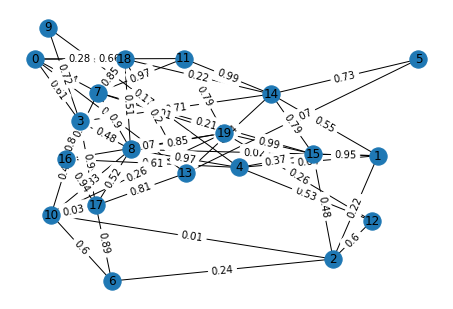

In [160]:
G = get_random_graph(20,0.2)
display_graph(G)

- Only 20 nodes, but not really possible to eyeball the best path!
- Let's try to find the best path using brute force recursion and see how it goes

In [163]:
def find_best_path_to_node(G,path,target_node):
    ''' find the best (shortest) path to target node
    
        Parameters
        ----------
        G: a weighted graph
        path: The list of nodes which is the path taken through G so far, node to be expanded is last
        target_node: the node to which a path is being found  
        
         Returns
        -------
        None (if no path exists)
        or a tuple consisting of
            the shortest distance from the current node to the target_node
            the entire path to the target_node (including path)
        '''
        
    if path[-1] == target_node:
        return [0,path]
    
    paths = []
    for v in G.neighbors(path[-1]):
        if v in path: # we need to remember the path so we don't backtrack
            continue
        distance = G.get_edge_data(path[-1],v)["weight"]
        #recursive step and processing result
        # my code here
        result = find_best_path_to_node(G,path + [v],target_node)
        if result:
            result = [result[0] + distance, result[1]]
            paths.append(result)
        # my code here
            
    if paths:
        return min(paths)
    else:
        return None

In [164]:
find_best_path_to_node(G,[5],6)

[1.1600000000000001, [5, 13, 17, 10, 2, 6]]

In [166]:
%timeit find_best_path_to_node(G,[5],6)

31.9 s ± 1.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


- This is really pretty slow. 
- Essentially, we are trying every possible path (that doesn't revisit nodes, since we know that's not going to help)
- Even with only a small number of nodes it isn't a practical solution to this problem

**Question:** Could we use some kind of directed depth first search to do better?

**Answer:** Not if we want to be sure we have found the best path. It's fairly easy to find a path between two nodes using some kind of search, but how do we know if it's the best one without trying out all possible paths?

- Intuitively, one of the problems with the recursive approach is that we are exploring the same paths over and over and over again, many of which are very bad paths. 
- Can we just remember something about possible subpaths that will eliminate the need to consider all of the exponential space of possibilities?
- Yup! For finding the rest of the path between two nodes, all that really matters about any given node between the two is its the minimum distance from the starting node (and the corresponding path).
- If we calculate these minimum distances for nodes in the graph generally, we will eventually find the shortest path to our goal.

**First try algorithm:** What about the following?

1. At step $i$, we have a list of nodes that are $i$ edges away from the start node. At the first step, this list of nodes is just the start node itself. Assume we have calculated minimum distances from the start node to these nodes (this is trivial for the start node, the distance is zero)
2. For each neighbor for each node in our $i$th set that we haven't visited before, we calculate the shortest distance from the start to this neighbor that goes though the current node by using the minimum distance we have already calculated for the $i$th node, and adding the weight of the edge to this new node, which will form part of our $i$+1th set.
3. There may (and likely will) be multiple paths from the set of $i$th nodes to any given node in the $i$+1the set. If so, we will just remember the shortest of these, overwriting any longer distances as we go along. At the same time, we should also remember which node from the $i$th resulted in this shortest distance, so we can calculate the final path.
4. If the start node is among those nodes we just found a minimum distance for, we are done! We construct the path back through the network using the "pointers" from each node
5. Otherwise, the $i$+1th set of nodes becomes the current set of nodes, and we go back to step 2.

**Question:** Does this work? 

**Answer:** Well, unfortunately no. We can demonstrate why not by constructing a counterexample.

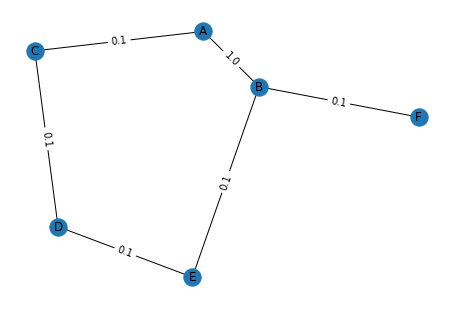

In [48]:
G = nx.Graph()

G.add_node("A")
G.add_node("B")
G.add_node("C")
G.add_node("D")
G.add_node("E")
G.add_node("F")

G.add_edge("A", "B", weight=1.0)
G.add_edge("B","F", weight=0.1)
G.add_edge("A", "C", weight=0.1)
G.add_edge("C", "D", weight=0.1)
G.add_edge("D", "E", weight=0.1)
G.add_edge("E", "B", weight=0.1)

display_graph(G)

- The problem with this is that we actually can't be sure we have the right minimum distance without potentially exploring paths that pass through more nodes.
- We could hack this algorithm into something that works if we allowed recalculation of minimum distance for entire sections of the graph based on updated info
- But this is not good dynamic programming; we would like to accurately solve our subproblems once and for all and avoid having to re-visit sections of the graph.
- Silver lining #1: This algorithm would actually work fine for unweighted graphs
- Silver lining #2: This general kind of algorithm actually works fine for most of the (more structured) problems where dynamic programming can be applied, including the lab!
- But for shortest paths in weighted graphs, we need something better: Dijkstra!

#### Dijkstra's algorithm

1. Similar to our last algorithm, for each node we will be storing its current shortest distance from the start, as well as any pointer back to the node on the corresponding path.
2. Again, we start with just the start node in our to_visit list, with its distance initialized to zero.
3. At each iteration, we will visit just one node, the one with the minimum distance from the start that we haven't visited before.
4. For each neighbor of that currently visited, we calculate the shortest distance from the start to this neighbor that goes though the current node by using the minimum distance we have calculated for that node, and adding the weight of the edge to this new node. If that distance is lower than the existing distance for that node, we update the distance and the back pointer
5. Go back to step 2. If the node we want to visit is the end node, we have found the shortest path. 

Wikipedia has a nice visualization![](https://upload.wikimedia.org/wikipedia/commons/5/57/Dijkstra_Animation.gif)


#### How does this solve the problem we had with the first try?

- In the first try, we were doing calculations based on potentially incorrect minimum distances
- But here, the closest (unvisited) node to the start will always have the correct minimum distance
- Why? Well let's show this by assuming it is false and creating a contradiction:
  - Suppose the distance of the closest unvisted node isn't actually minimal, which means there some hidden better path through a neighbor node one step closer to the start, one that we haven't visited
  - That neighbor node must have a shorter distance from the start than the current node, which means we should have expanded it according to the algorithm, unless it hasn't been seen. 
  - But it in turn must have another unvisited neighbor node one more step closer to the start with an ever lower distance, which we should have expanded unless it was unseen...
  - If we keep doing this, we must eventually reach the start node, but the start node is the first node visited, it can't be unseen.
  
Let's look at the code:

In [171]:
def dijkstra_find_shortest_path(G,start_node,target_node):
    ''' find the shortest path between two nodes in a weighted graph G using Dijkstra's algorithm'''
    min_distances_lookup = {}    
    min_distances_lookup[start_node] = [0, None]
    visited = set()
    to_visit = set([start_node])
    
    while to_visit:
        # find closest unvisted node
        #my code here
        current_node = min(to_visit, key=lambda node: min_distances_lookup[node][0]) #pick the closest node
        #my code here
        if current_node == target_node: # stop if we've found the node
            break            
        distance_to_current = min_distances_lookup[current_node][0]
    
        for v in G.neighbors(current_node): # look at each neighbor
            if v in visited:
                continue
            
            total_distance = G.get_edge_data(current_node,v)["weight"] + distance_to_current
            
            #update min_distance_lookup
            #my code here
            if v not in min_distances_lookup or min_distances_lookup[v][0] > total_distance:
                min_distances_lookup[v] = [total_distance,current_node]
            #my code here
            to_visit.add(v)
        visited.add(current_node)
        to_visit.discard(current_node)
            
    if current_node == target_node: # follow the pointer to build the path
        path = [target_node]
        while min_distances_lookup[path[-1]][-1] != None:
            path.append(min_distances_lookup[path[-1]][-1])
        path.reverse()
        return [min_distances_lookup[target_node][0],path]
    else:
        return None

Let's test it out on some graphs and see how it does

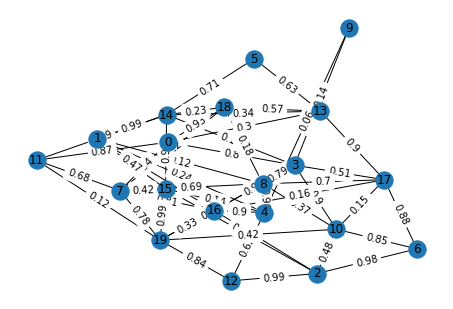

In [51]:
G = get_random_graph(20,0.2)
display_graph(G)

In [61]:
dijkstra_find_shortest_path(G,11,6)

[1.31, [11, 19, 8, 1, 2, 6]]

In [62]:
%timeit dijkstra_find_shortest_path(G,11,6)

103 µs ± 7.36 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [63]:
%timeit find_best_path_to_node(G,[11],6,0)

29 s ± 810 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
G = get_random_graph(1000,0.01)

In [66]:
%timeit dijkstra_find_shortest_path(G,random.randint(0,1000),random.randint(0,1000))

57.8 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


That looks nice and fast. So what are the big-$O$ properties of this algorithm?

**Space**: We need to store some fixed amount of information for each node, so $O(V)$

**Time**: The upper bound on the number of distance calculations required to carry out the algorithm to completion is just the number of edges, $O(E)$. The other consideration is the time required to identify the minimum distance node at each step. The way we have implemented it, at each step (corresponding to a visit of one node), we have to look through all the seen nodes to find the next one with the minimum distance, so $O(V^2)$. Combining these two the complexity of this implementation $O(E + V^2)$. It $is$ possible to do better than this, see the [wikipedia page](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) for more information.

For the problems where dynamic programming can be applied, using it usually means a huge speed up over the alternatives.

** Dynamic programming applications ** 
  - Image resizing (this week's lab!)
  - Syntactic parsing (in COLX 535)
  - String edit distance (in DSCI 563)
  - Using graph-based machine learning models such as HMMs (in also in DSCI 563)
  - DNA sequence alignment (okay, not part of this program!)
  - and more...

We aren't doing string edit distance in this course, but you can play around with this code that mimics the github diff using dynamic programming... 

In [89]:
#provided code
from IPython.display import HTML, display
import numpy as np

def num_diffs(x, y):
    """
    Compute the number of highlighted characters in the
    diff between x and y using dynamic programming.
    
    Parameters
    ----------
    x : str
        The first string
    y : str
        The second string
        
    Returns
    -------
    numpy.ndarray
        The dynamic programming table. 
        The last element is the result.
        
    Examples
    --------
    >>> num_diffs("This is a!", "this  is a")[-1,-1]
    4
    >>> num_diffs("xxHello", "Hellox")[-1,-1]
    3
    """   
    M = len(x)
    N = len(y)
    
    opt = np.zeros((M+1, N+1), dtype=int)
    opt[:,0] = np.arange(M+1)
    opt[0,:] = np.arange(N+1)
    
    for i in range(1,M+1):
        for j in range(1,N+1):
            if x[i-1] == y[j-1]:
                opt[i,j] = opt[i-1, j-1]
            else:
                opt[i,j] = 1 + min( opt[i-1,j], opt[i,j-1] )
    return opt

def show_diff(x, y):
    opt = num_diffs(x, y)
    
    x_highlight = ''
    y_highlight = ''
    i = len(x) 
    j = len(y)
    while i > 0 or j > 0:
        if i > 0 and j > 0 and x[i-1] == y[j-1]:
            x_highlight = x[i-1] + x_highlight
            y_highlight = y[j-1] + y_highlight
            i -= 1
            j -= 1
        elif j > 0 and opt[i, j] == opt[i, j-1] + 1:
            y_highlight = '<span style="background-color: rgba(0,255,0,0.5)">' + y[j-1] + '</span>' + y_highlight
            j -= 1
        else:
            x_highlight = '<span style="background-color: rgba(255,0,0,0.5)">' + x[i-1] + '</span>' + x_highlight
            i -= 1

#         print(i,j, x_highlight, y_highlight)
    
    x_highlight = '<span style="background-color: rgba(255,0,0,0.05)">' + x_highlight + "</span>"
    y_highlight = '<span style="background-color: rgba(0,255,0,0.05)">' + y_highlight + "</span>"
    
    display(HTML('<code>' + x_highlight + '</code>' + '<br>' + '<code>' + y_highlight + '</code>'))

In [90]:
show_diff("Hi there", "Hello there")

(Ironically, the colours do not render properly on GitHub - you need to run the notebook locally to see the highlighting.)

## Vectorization

Consider the code:

In [91]:
n = 10**7
x = np.zeros(n)
y = np.zeros(n)

In [92]:
%%timeit -n1 -r1

for i in range(n):
    y[i] = x[i] + 1

4.99 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Compare with:

In [93]:
x = np.zeros(n)

In [95]:
%%timeit -n1 -r1

y = x + 1 #this adds one to each element of x

41.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- Wow, this this ran about 200x faster! Why?!
- This is called **vectorization**.
- (Optional) This has to do with the Python language being _interpreted_ rather than _compiled_.
  - You may have worked with other languages, like C or Java, that had a compilation step.
  - Note: R is also interpreted.
- Numpy has some super-optimized code under the hood, for common operations like vector addition
  - Writing `x + 1` tells the interpreter to do vector addition which is fast.
  - Writing the loop has Python execute each step one at a time.
- It's often good to vectorize your code when possible, the speedups can be huge. 

**Vectorizing for Vectors**

Let's build a 100 X 1000 matrix where we assume each row corresponds to a vector, perhaps a feature vector for use in machine learning (coming soon!). Let's see what kind of speed ups we get by vectorizing various sensible operations on this group of vectors. In the process, we'll learn/practice a few standard numpy operators. For the first couple, we'll include both a pure Python and a numpy (but not fully vectorized) version
 

In [114]:
x = np.random.rand(100,1000)

What if we want the length of these vectors?

Pure Python

In [131]:
%%timeit -n1 -r1

for row in x:
    total = 0
    for num in row:
        total += num**2
    total**(0.5)

69 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Numpy nonvectorized

In [132]:
%%timeit -n1 -r1

for row in x:
  np.linalg.norm(x)    

15.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Vectorized

In [133]:
% timeit np.linalg.norm(x,axis=1)

129 µs ± 12.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Convert the vectors into a probability distribution (i.e they sum to 1)

Pure Python

In [134]:
%%timeit -n1 -r1

for row in x:
    total = 0
    for num in row:
        total += num
    for num in row:
        num/total

27.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Numpy nonvectorized

In [135]:
%%timeit -n1 -r1

for row in x:
  row / np.sum(row)

2.03 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Vectorized

In [136]:
%timeit x / np.sum(x,axis=1, keepdims=True) # broadcasting happening here!!! Only works with keepdims

179 µs ± 9.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Get the mean, standard deviation, highest value, and row index of the lowest value for each of the columns (features)

Nonvectorized

In [137]:
%%timeit -n1 -r1

for i in range(x.shape[1]):
    column = x[:,i]
    np.mean(column)
    np.std(column)
    np.max(column)
    np.argmin(column)
    

62.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Vectorized

In [138]:
%%timeit -n1 -r1

np.mean(x,axis=0)
np.std(x,axis=0)
np.max(x,axis=0)
np.argmin(x,axis=0)

1.86 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Weight the vector and sum (i.e. prediction using a linear regression model)

In [147]:
w = np.random.rand(1000)

(1000,)

Nonvectorized

In [151]:
%%timeit -n1 -r1

for row in x:
    np.dot(row,w)

1.08 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Vectorized

In [154]:
%timeit x @ w

123 µs ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### When should I vectorize my code?

- If you see a loop, ask yourself if each iteration is basically independent.
- If not, try to vectorize it.

#### Faster algorithms vs. faster implementations

- Sometimes we can speed up our code using a faster _algorithm_, like dynamic programming.
  - This usually means that it's actually different in big O, or the number of operations.
- Other times we speed it up using a faster _implementation_, like vectorization.
  - More of these approaches coming below.
- **These are two distinct approaches to speeding up your code.**
  - But sometimes they can be combined, e.g. in your lab this week.

## Parallelization

- [Moore's law](https://en.wikipedia.org/wiki/Moore%27s_law) states that computing power (number of transistors on a chip) will double approximately every 2 years. 
  - Shockingly, this held true for ~40 years.
  - Recently, progress has tapered off.
  - However, recently progress has been in **parallel** and **distributed** computation.

Consider our Fibonacci code from earlier:

In [34]:
def fib(n):
    f = np.zeros(n+1, dtype=int)
    f[1] = 1
    
    for i in range(2,n+1):
        f[i] = f[i-1] + f[i-2]
    
    return f[-1]

- The running time here is $O(n)$.
- Now consider our addition code:


In [35]:
def add_one(n, x):
    y = np.zeros(n)
    for i in range(n):
        y[i] = x[i] + 1
        
    return y

- The running time here is also $O(n)$.
- But this one can be done in parallel, because the $n$ computations _do not depend on each other_.
- On the other hand, each Fibonacci iteration depends on the previous two values.
- Both are $O(n)$, but they are fundamentally different.
- The requirements for code to be parallelized and vectorized are similar, though the two are not the same thing.

In [167]:
import multiprocessing

multiprocessing.cpu_count()

8

- My laptop has 8 cores. 
- I should theoretically be able to use them to run the code in parallel and achieve (close to) a 8x speedup.
- Recently, [GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit) have become extremely popular for parallel computing, especially in deep learning.
  - This will come up in DSCI 572 and beyond

**Warning**: 
- If you want to parallelize your own code, look some more at `multiprocessing` (not `threading`, which doesn't do true parallelization)
- But, relative to some other programming languages, Python is not great for parallelization
- At least, not great beyond the parallelization that is built into packages like Scikit Learn (for machine learning) and Pytorch (for neural networks)
- In some languages like C, it is easy to create multiple "threads" that can run on different CPUs but share memory, and thereby work side by side on some large data source.
- In Python, you have to use processes, which can't share memory, they can only pass messages back and forth
- My experience is that is only really useful in cases where there are large stretches of independent processing
- For instance, say, different processes extracting information from individual text documents
- And often you could accomplish this without using `multiprocessing` at all, instead just running entirely separate Python processes; this might be easier and not as wasteful as it sounds!
- Also, none of this will work properly in the context of Jupyter notebooks, you'll need to create standlone .py files



#### Parallel vs. distributed

- Parallel computing can happen even on one machine, e.g. my 4 cores
- Distributed computing means sharing the computation across machines.

Parallel computing is an entire field, so we don't do it much justice in this context...

## And more...

** Profiling **

- Profiling means measuring how long parts of your code takes.
- There are more sophisticated ones (e.g. [SnakeViz](https://jiffyclub.github.io/snakeviz/)) but we'll use the Python built-in [cProfile]().
- Profiling is useful when your code is slow but you don't know which parts.
- "Premature optimization is the root of all evil" -Donald Knuth
  - So, make sure you know what part of your code needs speeding up.
  - If something is only taking 1% of the time, don't work on making it faster.


In [178]:
import cProfile

G = get_random_graph(1000,0.01)

cProfile.run('dijkstra_find_shortest_path(G,343,234)')

         365705 function calls in 0.120 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   353217    0.050    0.000    0.050    0.000 <ipython-input-171-6de92ab45a36>:10(<lambda>)
        1    0.007    0.007    0.120    0.120 <ipython-input-171-6de92ab45a36>:2(dijkstra_find_shortest_path)
        1    0.000    0.000    0.120    0.120 <string>:1(<module>)
      691    0.000    0.000    0.001    0.000 graph.py:1226(neighbors)
     4507    0.001    0.000    0.001    0.000 graph.py:1327(get_edge_data)
        1    0.000    0.000    0.120    0.120 {built-in method builtins.exec}
      691    0.000    0.000    0.000    0.000 {built-in method builtins.iter}
      692    0.061    0.000    0.111    0.000 {built-in method builtins.min}
     5198    0.000    0.000    0.000    0.000 {method 'add' of 'set' objects}
       13    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.000    0

Wow, most of the our implementation of Dijkstra's algorithm is spent in the `min` function, maybe we do need to optimize what we are doing there (e.g. by keeping a sorted list)...

#### Numba

 
- "[Numba](http://numba.pydata.org/) is an open source JIT compiler that translates a subset of Python and NumPy code into fast machine code."
  - "JIT compiler" = Just-in-time compiler.
  - It sees a loop and figures out that it's actually vector addition, right before the loop is executed (hence "just in time").
  - Basically, it provides behind-the-scenes vectorization

#### Cython

- [Cython](https://cython.org/) allows the user to leverage the increased speed of C within Python.
- You can call C routines, which are usually way faster
- You can also change your Python variables to C variables within Python for faster calculations  
- Note: it's the also thing to use if you want to compile your code to create an standalone executable
  - E.g. you want to allow someone to run your Python program without forcing them to have Python

#### PyPy

- [PyPy](https://pypy.org/) is an implementation of Python in Python.
  - The original Python, or CPython, is written in C.
  - PyPy has several advantages including a just-in-time compiler which might make your code run faster.
- You can install PyPy and run your code with `pypy test.py` instead of `python test.py`.
  - You don't need to change your code, BUT some libraries may not work with PyPy. Things like numpy do work. For more info, see [here](https://pypy.org/compat.html).

Note! This has nothing to do with [PyPI](https://pypi.org/), which is the package index, like [CRAN](https://cran.r-project.org/) for R. 